In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import glob
import dill
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import lightning as L
from collections import OrderedDict

import sys
sys.path.append("../electric-properties-only")
sys.path.append("../end-to-end")
sys.path.append("../end-to-end-with-feedback")
sys.path.append("../../efish-physics-model/objects")
sys.path.append("../../efish-physics-model/helper_functions")
sys.path.append("../../efish-physics-model/uniform_points_generation")

# from helpers_conv_nn_models import make_true_vs_predicted_figure
from electric_images_dataset import ElectricImagesDataset
from EndToEndConvNN import EndToEndConvNN
from EndToEndConvNN_PL import EndToEndConvNN_PL
from EndToEndConvNNWithFeedback import EndToEndConvNNWithFeedback
from EndToEndConvNNWithFeedback_PL import EndToEndConvNNWithFeedback_PL

## Load trained Models

In [3]:
models = pd.DataFrame()

#### Prepare dataset for dummy run to initialize LazyLayers

In [4]:
batch_size = 5000
data_dir_name = "../../efish-physics-model/data/processed/data-2024_06_18-characterization_dataset"
dset = ElectricImagesDataset(data_dir_name=data_dir_name, fish_t=20, fish_u=30)

#### Load full end-to-end models

In [5]:
for folder in list(np.sort(glob.glob("stats-panel/full-model*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNN_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat([models, pd.DataFrame({"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type":"full", "model": [model]})]).reset_index(drop=True)

/home/dturcu/.conda/envs/efish/lib/python3.12/site-packages/torch/nn/modules/lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [6]:
for folder in list(np.sort(glob.glob("stats-panel/feedback-with-values*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNNWithFeedback_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat([models, pd.DataFrame({"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type":"feedback_vals", "model": [model]})]).reset_index(drop=True)

for folder in list(np.sort(glob.glob("stats-panel/feedback-with-estimates*"))):
    checkpoint_path = f"{folder}/lightning_logs/version_0/checkpoints/epoch=4-step=25015.ckpt"
    model = EndToEndConvNNWithFeedback_PL.load_from_checkpoint(checkpoint_path)
    model.eval()
    model.freeze()
    model.cpu()
    rand_seed = int(folder.split("_")[1].split("-")[0])
    lambda_RC = int(folder.split("_")[-1])
    models = pd.concat([models, pd.DataFrame({"rand_seed": [rand_seed], "lambda_RC": [lambda_RC], "model_type":"feedback_esti", "model": [model]})]).reset_index(drop=True)

In [7]:
valid_data = dict()
for rand_seed in models["rand_seed"].unique():
    L.seed_everything(rand_seed)
    _, valid_dset = torch.utils.data.random_split(dset, [0.75, 0.25])  # type: ignore
    valid_data[rand_seed] = DataLoader(valid_dset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=12)

Seed set to 11


Seed set to 113


## Compute overall R2 score

In [8]:
def compute_overall_r2_score(dfrow, valid_data=valid_data):
    model = dfrow["model"]
    model_type = dfrow["model_type"]
    rand_seed = dfrow["rand_seed"]
    valid_dloader = valid_data[rand_seed]
    y_true = []
    y_pred = []
    num_batches = 0
    for x, y in valid_dloader:
        if model_type == "full":
            y_pred.append(model.model(x).detach().numpy())
        elif model_type == "feedback":
            y_pred.append(model.model(x, distances=y[:, 1], radii=y[:, 3]).detach().numpy())
        y_true.append(y.detach().numpy())
        num_batches += 1
        if num_batches >= 24:
            break
    y_true = np.vstack(y_true)
    y_pred = np.vstack(y_pred)
    for i, feat_name in enumerate(["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]):
        dfrow[f"r2_score_{feat_name}"] = r2_score(y_true[:,i], y_pred[:,i])
    return dfrow

In [10]:
# models_with_r2 = models[:1].apply(compute_overall_r2_score, axis=1)
models_with_r2 = models.apply(compute_overall_r2_score, axis=1)
models_with_r2.drop(columns=["model"]).to_csv("models_with_r2.csv", index=False)
# models_with_r2.drop(columns=["model"]).to_csv("models_with_r2_estimates.csv", index=False)

In [11]:
def compute_prediction_with_multiple_eods(y, y_hat, n_eods):
    y_hat_multiple_eods = []
    for i in range(y.shape[1]):
        vals, indices = torch.unique(y[:, i], return_inverse=True)
        temp_y_hat = torch.zeros_like(y_hat[:, i])
        for j in range(len(vals)):
            avg_response = y_hat[indices == j, i].mean().item()
            std_response = (y_hat[indices == j, i].std() / np.sqrt(n_eods)).item()
            temp_y_hat[indices == j] = torch.normal(avg_response, std_response, size=((indices == j).sum().item(),))
        y_hat_multiple_eods.append(temp_y_hat)
    return torch.vstack(y_hat_multiple_eods).T


def compute_overall_r2_score_multiple_eods(dfrow, valid_data=valid_data, num_eods=[1, 2, 3, 4, 5, 10, 20, 40]):
    model = dfrow["model"]
    model_type = dfrow["model_type"]
    rand_seed = dfrow["rand_seed"]
    valid_dloader = valid_data[rand_seed]
    num_batches = 0
    for neods in num_eods:
        y_true = []
        y_pred = []
        for x, y in valid_dloader:
            if model_type == "full":
                y_hat = model.model(x)
                y_hat = compute_prediction_with_multiple_eods(y, y_hat, neods)
                y_pred.append(y_hat.detach().numpy())
            elif model_type == "feedback":
                y_hat = model.model(x, distances=y[:, 1], radii=y[:, 3])
                y_hat = compute_prediction_with_multiple_eods(y, y_hat, neods)
                y_hat = model.model(x, distances=y_hat[:, 1], radii=y_hat[:, 3])
                y_hat = compute_prediction_with_multiple_eods(y, y_hat, neods)
                y_pred.append(y_hat.detach().numpy())
            y_true.append(y.detach().numpy())
            num_batches += 1
            if num_batches >= 24:
                break
        y_true = np.vstack(y_true)
        y_pred = np.vstack(y_pred)
        for i, feat_name in enumerate(
            ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"]
        ):
            dfrow[f"r2_score_{feat_name}_num_eods_{neods}"] = r2_score(y_true[:, i], y_pred[:, i])
    return dfrow

In [ ]:
# models_with_r2_multiple_eods = models[:1].apply(compute_overall_r2_score_multiple_eods, axis=1)
models_with_r2_multiple_eods = models.apply(compute_overall_r2_score_multiple_eods, axis=1)
models_with_r2_multiple_eods.drop(columns=["model"]).to_csv("models_with_r2_multiple_eods.csv", index=False)
# models_with_r2_multiple_eods.drop(columns=["model"]).to_csv("models_with_r2_multiple_eods_estimates.csv", index=False)

# Check feedback model with estimates

In [9]:
models

,rand_seed,lambda_RC,model_type,model
0,11,0,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
1,11,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
2,11,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
3,11,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
4,11,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
5,11,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
6,113,0,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
7,113,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
8,113,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
9,113,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...


In [10]:
def make_true_vs_predicted_figure(
    true_vals: np.ndarray,
    pred_vals: np.ndarray,
    feature_names: list[str] = ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"],
    title_names: list[str] = ["Lateral position (mm)", "Distance (mm)", "Vertical position (mm)", "Radius (mm)", "Resistance (log)", "Capacitance (log)"],
) -> plt.Figure:  # type: ignore
    """Create a figure comparing the true and predicted values for each feature.

    Args:
        true_vals (np.ndarray): True values.
        pred_vals (np.ndarray): Predicted values.
        feature_names (list[str], optional): Names of the features in the columns of the values.
            Defaults to ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"].

    Returns:
        plt.figure.Figure: Figure object containing the comparison.
    """
    
    fig, ax = plt.subplots(1, true_vals.shape[-1], figsize=(2 * true_vals.shape[-1], 2))
    for i in range(true_vals.shape[-1]):
        feat_mean = dset.worms_properties_stats[feature_names[i]]["mean"]
        feat_std = dset.worms_properties_stats[feature_names[i]]["std"]
        if i < 4:
            feat_mean = feat_mean * 1e3
            feat_std = feat_std * 1e3
        if i == 0:
            feat_mean = - feat_mean
            feat_std = - feat_std
        if i == 1:
            feat_mean = feat_mean - 9
        true_vs = true_vals[:, i] * feat_std + feat_mean
        pred_vs = pred_vals[:, i] * feat_std + feat_mean
        ax[i].scatter(true_vs, pred_vs, c='k', s=1, alpha=0.5, marker=".")
        ax[i].plot([true_vs.min(), true_vs.max()], [true_vs.min(), true_vs.max()], ls="--", c="k", lw=0.5)
        ax[i].set_xlabel("True", fontsize=8)
        if i == 0:
            ax[i].set_ylabel("Predicted", fontsize=8)
        # ax[i].set_title(title_names[i], fontsize=10)
        ax[i].set_title(f"{title_names[i]}\n$R^2$ = {r2_score(true_vs, pred_vs):.3f}", fontsize=10)
        ax[i].tick_params(axis="both", which="major", labelsize=6)
        ax[i].axis("equal")
        sns.despine(ax=ax[i], offset=0, trim=True)
    plt.tight_layout()
    return fig

In [11]:
dset.worms_properties_stats

{'resistances': {'mean': 3.848484848485048, 'std': 0.6989431980200183},
 'capacitances': {'mean': -9.15151515151503, 'std': 0.6989431980327792},
 'radii': {'mean': 0.0054999999999999945, 'std': 0.0027386128284640925},
 'position_xs': {'mean': -0.05000000000000003, 'std': 0.027386128286089},
 'position_ys': {'mean': 0.02900000000000005, 'std': 0.006055300798828547},
 'position_zs': {'mean': 2.080228652944331e-25, 'std': 0.006324555414262988}}

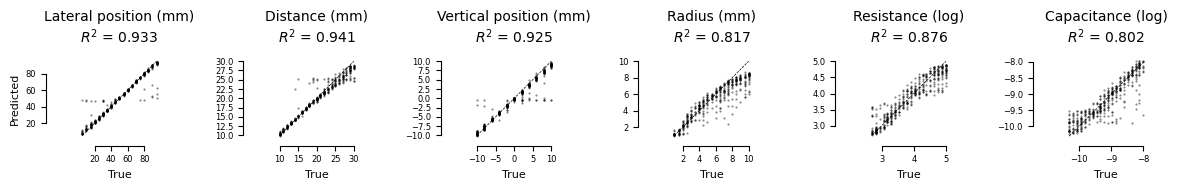

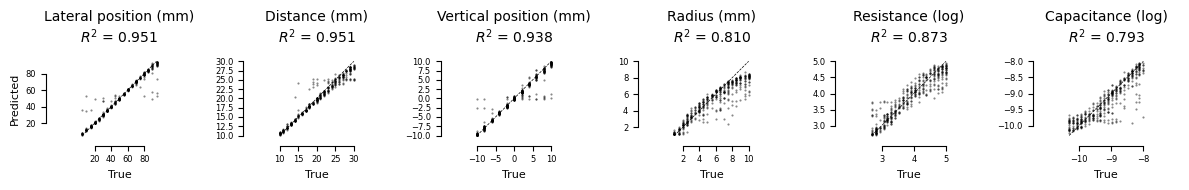

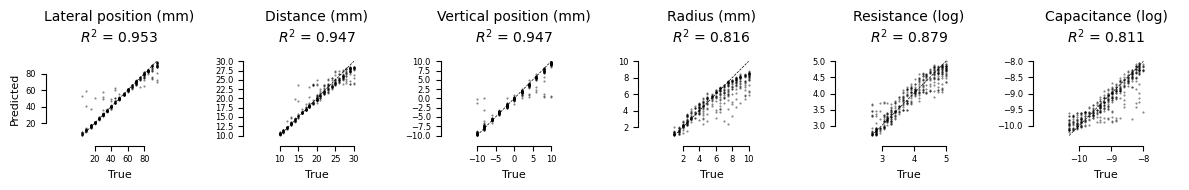

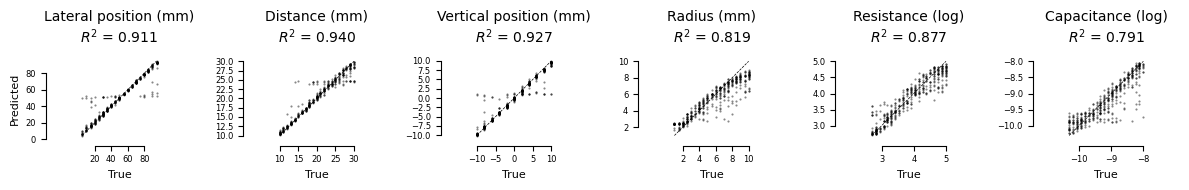

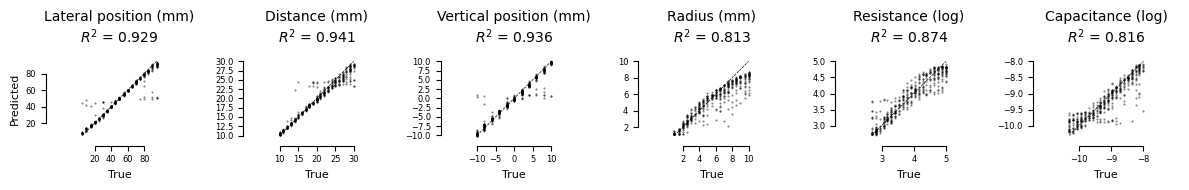

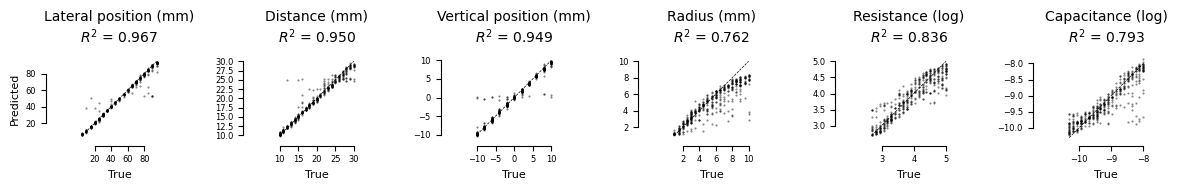

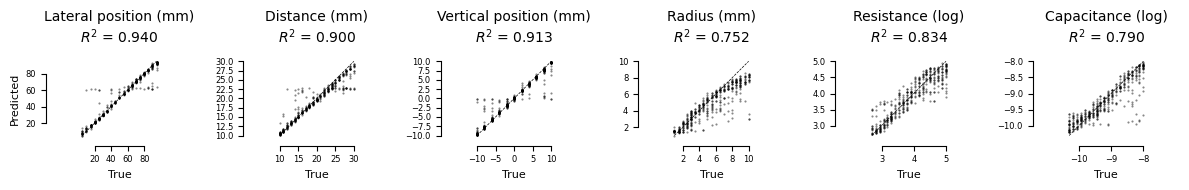

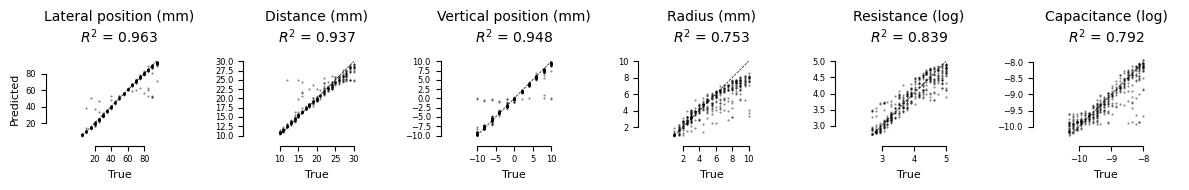

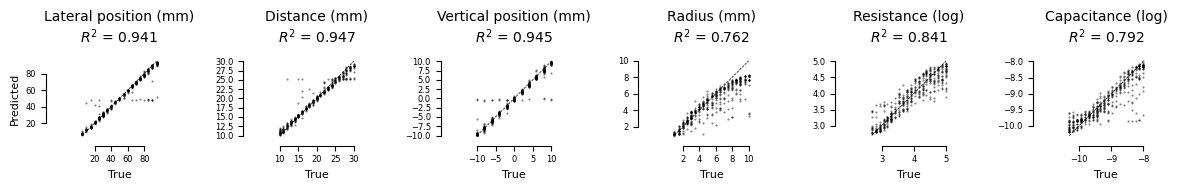

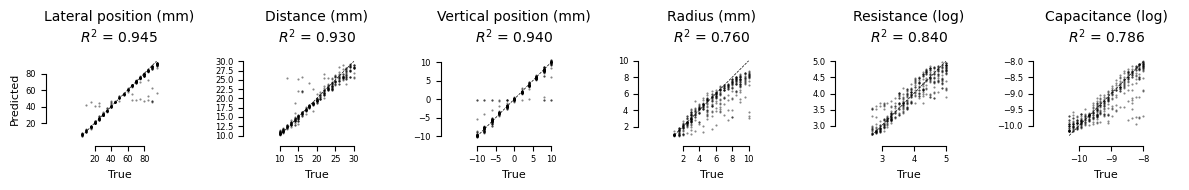

In [12]:
for i in [13,14,15,16,17,19,20,21,22,23]:
    my_model = models.loc[i]
    my_rand_seed = my_model["rand_seed"]
    my_model = my_model["model"]
    my_loader = valid_data[my_rand_seed]
    my_batch = next(iter(my_loader))
    my_x = my_batch[0]
    my_y = my_batch[1]
    my_y_hat = my_model.model(my_x, distances=my_y[:, 1], radii=my_y[:, 3])

    fig = make_true_vs_predicted_figure(my_y.detach().numpy()[:400], my_y_hat.detach().numpy()[:400])
    plt.savefig("true_vs_predicted-feedback.svg")
    plt.show()

    # neods = 10
    # my_y_hat = compute_prediction_with_multiple_eods(my_y, my_y_hat, neods)
    # my_y_hat = my_model.model(my_x, distances=my_y_hat[:, 1], radii=my_y_hat[:, 3])
    # my_y_hat = compute_prediction_with_multiple_eods(my_y, my_y_hat, neods)
    # # my_y_hat_temp = compute_prediction_with_multiple_eods(my_y, my_y_hat, neods)
    # # my_y_hat = torch.hstack([my_y_hat_temp[:,:4], my_y_hat[:,4:]])

    # fig = make_true_vs_predicted_figure(my_y.detach().numpy()[:400], my_y_hat.detach().numpy()[:400])
    # plt.show()

In [12]:
print(np.mean([876, 873, 879, 877, 874, 836, 834, 839, 841, 840]), np.std([876, 873, 879, 877, 874, 836, 834, 839, 841, 840]))
print(np.mean([802, 793, 811, 791, 816, 793, 790, 792, 792, 786]), np.std([802, 793, 811, 791, 816, 793, 790, 792, 792, 786]))

856.9 19.049671913185275
796.6 9.318798205777394


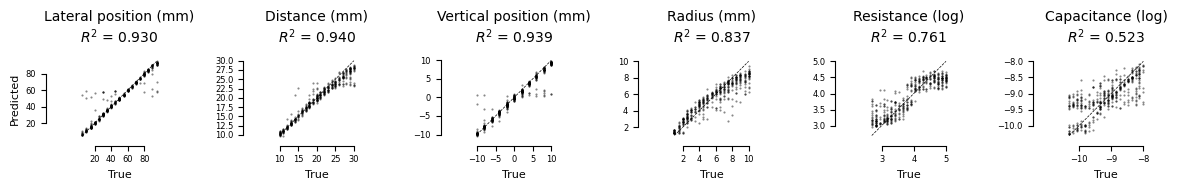

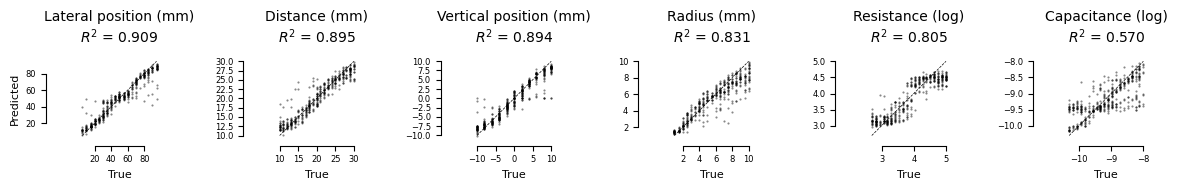

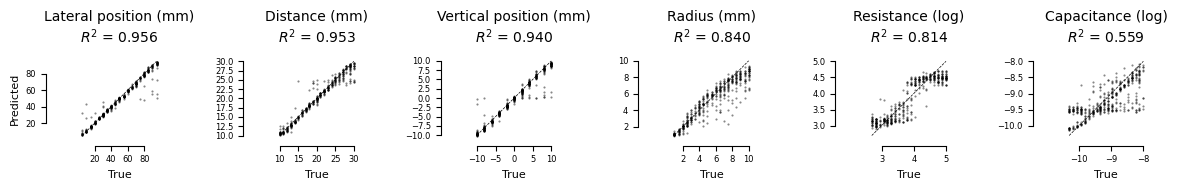

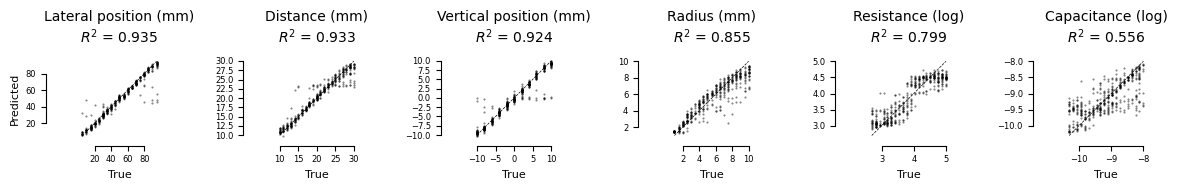

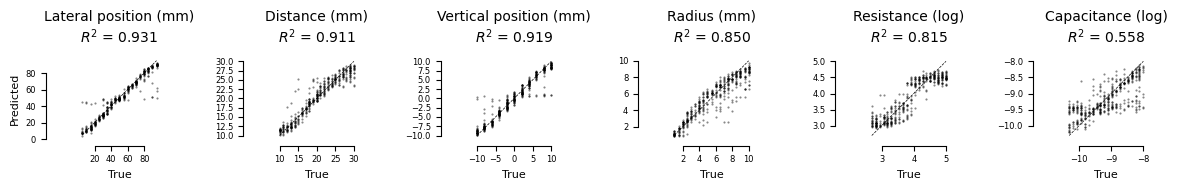

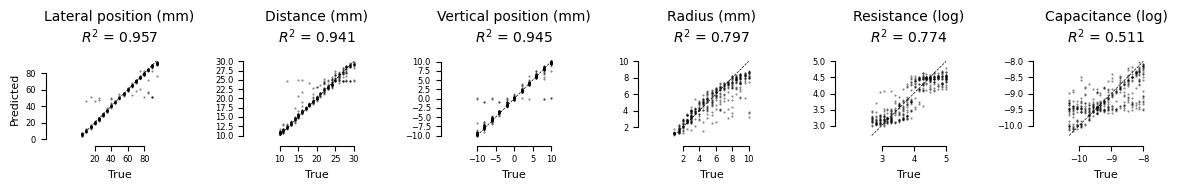

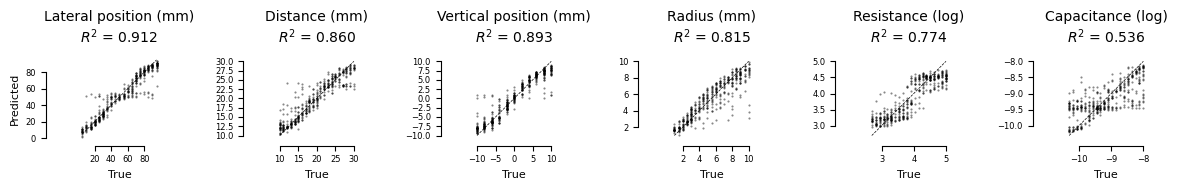

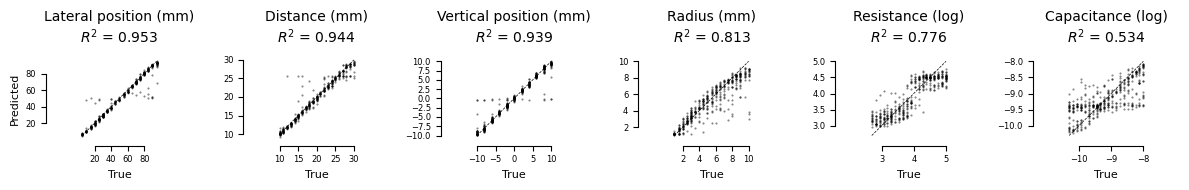

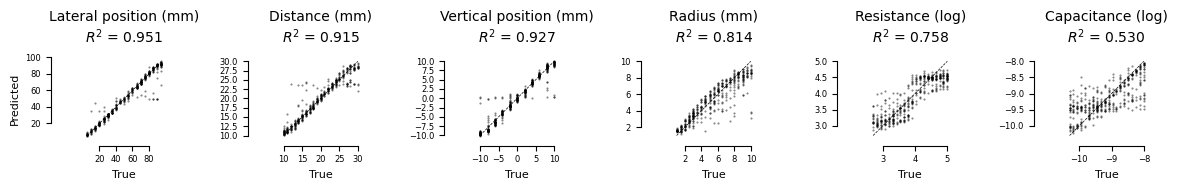

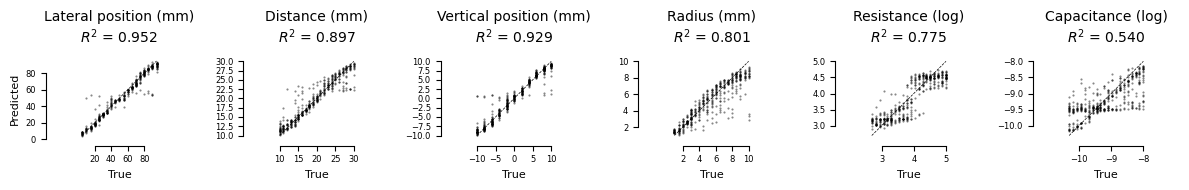

In [13]:
for i in [1,2,3,4,5,7,8,9,10,11]:
    my_model = models.loc[i]
    my_rand_seed = my_model["rand_seed"]
    my_model = my_model["model"]
    my_loader = valid_data[my_rand_seed]
    my_batch = next(iter(my_loader))
    my_x = my_batch[0]
    my_y = my_batch[1]
    my_y_hat = my_model.model(my_x)

    fig = make_true_vs_predicted_figure(my_y.detach().numpy()[:400], my_y_hat.detach().numpy()[:400])
    plt.savefig("true_vs_predicted-no_feedback.svg")
    plt.show()

    # neods = 10
    # my_y_hat = compute_prediction_with_multiple_eods(my_y, my_y_hat, neods)

    # fig = make_true_vs_predicted_figure(my_y.detach().numpy()[:400], my_y_hat.detach().numpy()[:400])
    # plt.show()

In [14]:
print(np.mean([930, 909, 956, 935, 931, 957, 912, 953, 951, 952]), np.std([930, 909, 956, 935, 931, 957, 912, 953, 951, 952]))
print(np.mean([897, 915, 944, 860, 941, 911, 933, 953, 895, 940]), np.std([897, 915, 944, 860, 941, 911, 933, 953, 895, 940]))
print(np.mean([929, 927, 939, 893, 945, 919, 924, 940, 894, 939]), np.std([929, 927, 939, 893, 945, 919, 924, 940, 894, 939]))
print(np.mean([801, 814, 813, 815, 797, 850, 855, 840, 831, 837]), np.std([801, 814, 813, 815, 797, 850, 855, 840, 831, 837]))
print(np.mean([775, 758, 776, 774, 774, 815, 799, 814, 805, 761]), np.std([775, 758, 776, 774, 774, 815, 799, 814, 805, 761]))
print(np.mean([540, 530, 534, 536, 511, 558, 556, 559, 570, 523]), np.std([540, 530, 534, 536, 511, 558, 556, 559, 570, 523]))

938.6 17.059894489708896
918.9 27.427905497868405
924.9 17.489711261195822
825.3 19.115700353374447
785.1 20.16159715895544
541.7 17.590054007876155


# True vs. Predicted Example Panel

In [13]:
batch_size = 400
valid_data = dict()
for rand_seed in models["rand_seed"].unique():
    L.seed_everything(rand_seed)
    _, valid_dset = torch.utils.data.random_split(dset, [0.75, 0.25])  # type: ignore
    valid_data[rand_seed] = DataLoader(valid_dset, batch_size=batch_size, shuffle=False, drop_last=True, num_workers=12)

Seed set to 11


Seed set to 113


In [14]:
def make_true_vs_predicted_figure(
    true_vals: np.ndarray,
    pred_vals: np.ndarray,
    feature_names: list[str] = ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"],
    title_names: list[str] = [
        "Lateral position (mm)",
        "Distance (mm)",
        "Vertical position (mm)",
        "Radius (mm)",
        "Resistance (log)",
        "Capacitance (log)",
    ],
) -> plt.Figure:  # type: ignore
    """Create a figure comparing the true and predicted values for each feature.

    Args:
        true_vals (np.ndarray): True values.
        pred_vals (np.ndarray): Predicted values.
        feature_names (list[str], optional): Names of the features in the columns of the values.
            Defaults to ["position_xs", "position_ys", "position_zs", "radii", "resistances", "capacitances"].

    Returns:
        plt.figure.Figure: Figure object containing the comparison.
    """

    fig, ax = plt.subplots(1, true_vals.shape[-1], figsize=(3 * true_vals.shape[-1], 3))
    for i in range(true_vals.shape[-1]):
        feat_mean = dset.worms_properties_stats[feature_names[i]]["mean"]
        feat_std = dset.worms_properties_stats[feature_names[i]]["std"]
        if i < 4:
            feat_mean = feat_mean * 1e3
            feat_std = feat_std * 1e3
        if i == 0:
            feat_mean = -feat_mean
            feat_std = -feat_std
        if i == 1:
            feat_mean = feat_mean - 9
        true_vs = true_vals[:, i] * feat_std + feat_mean
        pred_vs = pred_vals[:, i] * feat_std + feat_mean
        ax[i].scatter(true_vs, pred_vs, c=true_vals[:, 3], s=20, alpha=1, marker="o", linewidths=0)
        # ax[i].scatter(true_vs, pred_vs, c="k", s=20, alpha=1, marker="o", linewidths=0)
        ax[i].plot([true_vs.min(), true_vs.max()], [true_vs.min(), true_vs.max()], ls="--", c="k", lw=1)
        # ax[i].set_xlabel("True", fontsize=12)
        # if i == 0:
        #     ax[i].set_ylabel("Predicted", fontsize=12)
        ax[i].set_title(title_names[i], fontsize=13)
        # ax[i].set_title(f"{title_names[i]}\n$R^2$ = {r2_score(true_vs, pred_vs):.3f}", fontsize=10)
        ax[i].tick_params(axis="both", which="major", labelsize=12)
        ax[i].set_yticks(ax[i].get_xticks())
        ax[i].axis("equal")
        sns.despine(ax=ax[i], offset=dict(left=-20, bottom=-10), trim=True)
    plt.tight_layout()
    return fig

In [15]:
models

,rand_seed,lambda_RC,model_type,model
0,11,0,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
1,11,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
2,11,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
3,11,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
4,11,4,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
5,11,8,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
6,113,0,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
7,113,1,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
8,113,16,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...
9,113,2,full,EndToEndConvNN_PL(\n (model): EndToEndConvNN2...


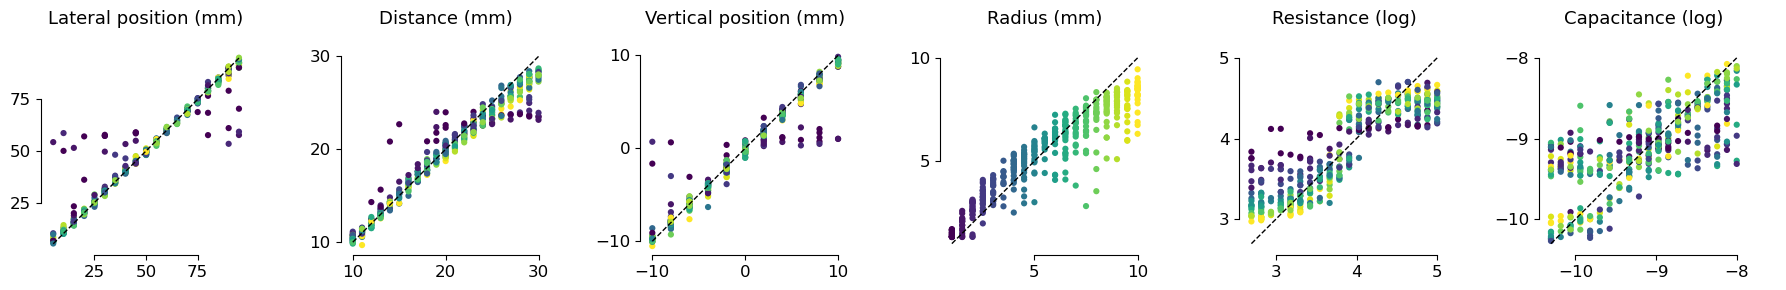

In [16]:
# full model, no feedback
my_model = models.loc[1]
my_rand_seed = my_model["rand_seed"]
my_model = my_model["model"]
my_loader = valid_data[my_rand_seed]
my_batch = next(iter(my_loader))
my_x = my_batch[0]
my_y = my_batch[1]
my_y_hat = my_model.model(my_x)

fig = make_true_vs_predicted_figure(my_y.detach().numpy(), my_y_hat.detach().numpy())
plt.savefig("true_vs_predicted-full_no_feedback.svg")
plt.show()

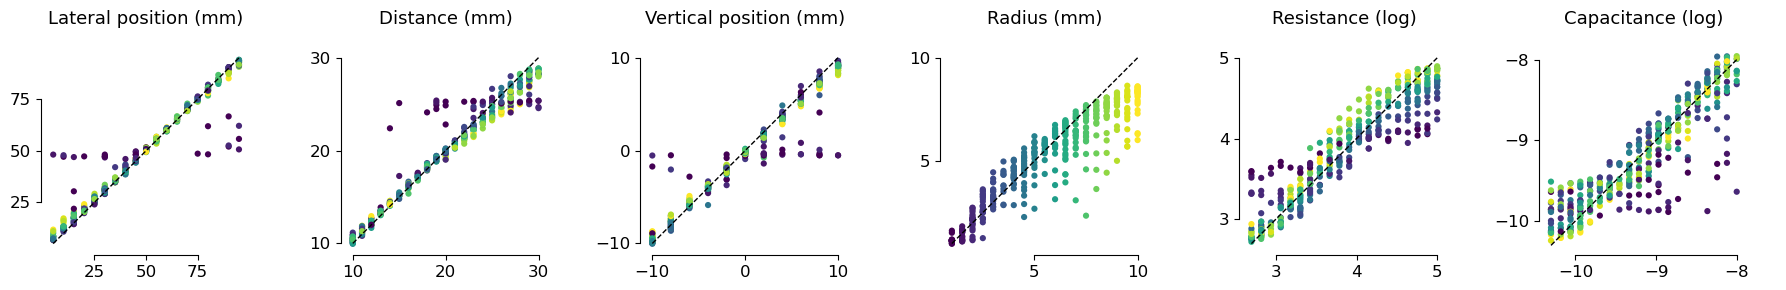

In [17]:
# full model, feedback values
my_model = models.loc[13]
my_rand_seed = my_model["rand_seed"]
my_model = my_model["model"]
my_loader = valid_data[my_rand_seed]
my_batch = next(iter(my_loader))
my_x = my_batch[0]
my_y = my_batch[1]
my_y_hat = my_model.model(my_x, distances=my_y[:, 1], radii=my_y[:, 3])

fig = make_true_vs_predicted_figure(my_y.detach().numpy(), my_y_hat.detach().numpy())
plt.savefig("true_vs_predicted-full_feedback_values.svg")
plt.show()

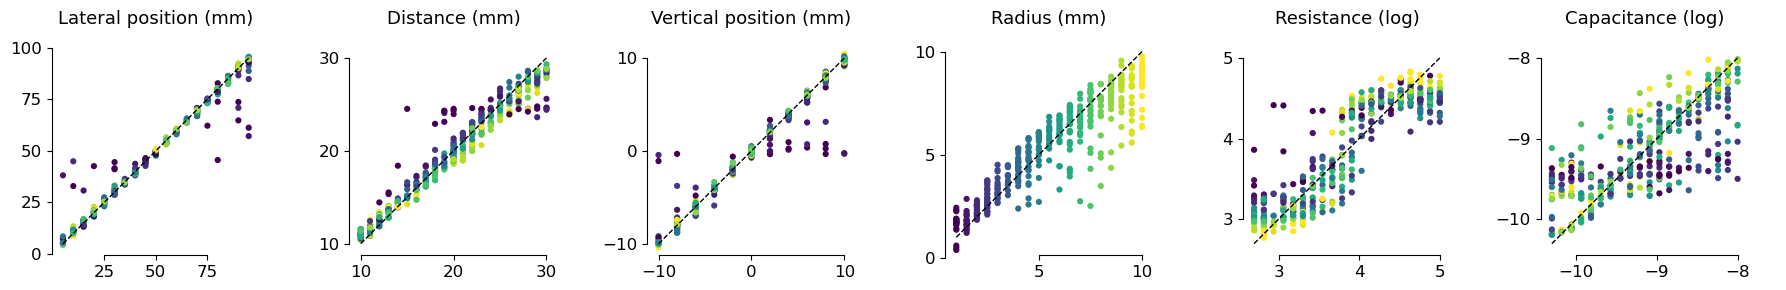

In [18]:
# full model, feedback estimates
my_model = models.loc[25]
my_rand_seed = my_model["rand_seed"]
my_model = my_model["model"]
my_loader = valid_data[my_rand_seed]
my_batch = next(iter(my_loader))
my_x = my_batch[0]
my_y = my_batch[1]
my_y_hat = my_model.model(my_x, distances=my_y[:, 1], radii=my_y[:, 3])

fig = make_true_vs_predicted_figure(my_y.detach().numpy(), my_y_hat.detach().numpy())
plt.savefig("true_vs_predicted-full_feedback_estimates.svg")
plt.show()